# Imports

In [1]:
import numpy as np
import os
import numpy as np
import gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import animation
from IPython.display import HTML

In [2]:
%matplotlib inline

import gym
env = gym.make('CartPole-v0',render_mode='rgb_array')
env.reset()
frames = []
for _ in range(1000):
    frame = env.render()
    env.step(env.action_space.sample()) # take a random action
    frames.append(frame)
env.close()

video = np.array(frames)
fig = plt.figure()
im = plt.imshow(frames[0])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0])

def animate(i):
    im.set_data(video[i])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=50)
HTML(anim.to_html5_video()) # this might take a little bit to run

/home/hesam/anaconda3/envs/mujoco_env/lib/python3.9/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/home/hesam/anaconda3/envs/mujoco_env/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/hesam/anaconda3/envs/mujoco_env/lib/python3.9/site-packages/gym/envs/classic_control/cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


# Define some global variables

In [2]:
# maximum number of training episodes
NUM_EPISODES = 90
# maximum number of steps per episode
# CartPole-V0 has a maximum of 200 steps per episodes
MAX_EP_STEPS = 200
# reward discount factor
GAMMA = .6
# once MAX_EPISODES or ctrl-c is pressed, number of test episodes to run
NUM_TEST_EPISODES = 3
# batch size used for the training
BATCH_SIZE = 1000
# maximum number of transitions stored in the replay buffer
MAX_REPLAY_BUFFER_SIZE = BATCH_SIZE * 10
# reward that is returned when the episode terminates early (i.e. the controller fails)
FAILURE_REWARD = -10.

# setting the random seed makes things reproducible
random_seed = 8
np.random.seed(random_seed)

# Define the Actor class

In [ ]:
class Actor(nn.Module):

  def __init__(self, state_dim, action_dim):
    """An actor for Actor-Critic reinforcement learning.

    This actor represent a stochastic policy. It predicts a distribution over
    actions condition on a given state. The distribution can then be sampled to
    produce an single control action.

    Arguments:
        state_dim: an integer, number of states of the system
        action_dim: an integer, number of possible actions of the system
    Returns:
        nothing
    """
    super().__init__()
    self.state_dim = state_dim
    self.action_dim = action_dim

    # the neural network (input will be state, output is unscaled probability distribution)
    self.nn = nn.Sequential(
        nn.Linear(state_dim, 128),
        nn.ReLU(),
        nn.Linear(128, action_dim)
    )

  def forward(self, state, action, td_error):
    """Runs the forward pass and gets the expected value

    Arguments:
        state: a tensor representing a batch of states (batch_size X
        state_dim)
        action: a tensor of integers representing a batch of actions
        (batch_size X 1)
        where the integers correspond to the action number (0 indexed)
        td_error: a tensor of floats (batch_size X 1) the temporal
        differences
    Returns:
        expected_v: a tensor of the expected reward for each of the
        samples in the batch (batch_size X 1)
    """

    action_logits = self.nn(state)
    action_probs = nn.Softmax()(action_logits)
    clipped_action_probs = torch.clip(action_probs, 1e-14, 1.0)
    action_oh = torch.nn.functional.one_hot(action[:, 0].long())
    log_action_probs = (torch.log(clipped_action_probs) * action_oh).sum(axis=1, keepdims=True)
    expected_v = log_action_probs * td_error
    return expected_v

  def get_action(self, state):
    """Get an action for a given state by predicting a probability distribution over actions and sampling one.

    Arguments:
        state: a tensor of size (state_dim) representing the current
        state
    Returns:
        action: an integer (0 indexed) corresponding to the action taken
        by the actor
    """
    logits = self.nn(state.unsqueeze(0))
    action_probs = nn.Softmax()(logits)
    action = np.random.choice(self.action_dim, p=action_probs.detach().numpy()[0, :])
    return action

# Define the Critic class

In [ ]:
class Critic(nn.Module):

  def __init__(self, state_dim):
    """A critic for Actor-Critic reinforcement learning.

    This critic works by estimating a value function (expected reward-to-go) for
    given states. It is trained using Temporal Difference error learning (TD
    error).

    Arguments:
        state_dim: an interger, number of states of the system
    Returns:
        nothing
    """
    super().__init__()
    self.state_dim = state_dim

    # the loss functions described in the writeup.
    # the neural network (input will be state, output is unscaled value)
    self.nn = nn.Sequential(
        nn.Linear(state_dim, 128),
        nn.ReLU(),
        nn.Linear(128, 1)
    )

    
  def forward(self, state, reward, state_next):
    """Runs the training step

    Arguments:
        state: a tensor representing a batch of initial states
        (batch_size X state_dim)
        reward: a tensor representing a batch of rewards (batch_size X
        1)
        state_next: a tensor representing a batch of 'future states'
        (batch_size X state_dim)
        each sample (state, reward, state_next) correspond to a given
        transition
    Returns:
        td_error: the td errors of the batch, as a numpy array
        (batch_size X 1)
    """
    value = self.nn(state)
    next_value = self.nn(state_next.unsqueeze(0))
    td_error = reward + GAMMA * next_value - value

    return td_error

# Inference function

In [5]:
def run_actor(env, actor, num_episodes, render=True):
  """Runs the actor on the environment for num_episodes

  Arguments:
      env: the openai gym environment
      actor: an instance of the Actor class
      num_episodes: number of episodes to run the actor for
  Returns:
      nothing
  """
  for i_episode in range(num_episodes):
    state = env.reset()[0]
    state = torch.Tensor(state)
    total_reward = 0.0
    for t in range(MAX_EP_STEPS):
      if render:
        env.render()
      action = actor.get_action(state)
      a = env.step(action)
      state, reward, done, info = a[0:4]
      state = torch.Tensor(state)
      total_reward += reward
      if done:
        print("Reward: ", str(total_reward))
        break

# Training Loop

In [6]:
def train_actor_critic():
  # setup the OpenAI gym environment
  env = gym.make('CartPole-v0',render_mode='rgb_array')
  state_dim = env.observation_space.shape[0]
  action_dim = env.action_space.n
  print("state dim: ", state_dim, "action dim: ", action_dim)
  print("state dim: ", state_dim)
  print("action dim: ", action_dim)

  # create an actor and a critic network and initialize their variables
  actor = Actor(state_dim, action_dim)
  critic = Critic(state_dim)

  actor_optim = optim.Adam(actor.parameters(), lr=3e-4)
  critic_optim = optim.Adam(critic.parameters(), lr=3e-4)

  # the replay buffer will store observed transitions
  replay_buffer = np.zeros((0, 2 * state_dim + 2))

  # allocate memory to keep track of episode rewards
  reward_history = np.zeros(NUM_EPISODES)

  for i_episode in range(NUM_EPISODES):
    # very inneficient way of making sure the buffer isn't too full
    if replay_buffer.shape[0] > MAX_REPLAY_BUFFER_SIZE:
      replay_buffer = replay_buffer[-MAX_REPLAY_BUFFER_SIZE:, :]

    # reset the OpenAI gym environment to a random initial state for each episode
    state = env.reset(seed=random_seed)[0]
    #print(state)
    state = torch.Tensor(state)
    #print(state)
    episode_reward = 0.0

    for t in range(MAX_EP_STEPS):
      # uses the actor to get an action at the current state
      action = actor.get_action(state)
      # call gym to get the next state and reward, given we are taking action at the current state
      a = env.step(action)
      state_next, reward, done, info = a[0:4]
      #state_next, reward, done, info = env.step(action)
      state_next = torch.Tensor(state_next)

      # done=True means either the cartpole failed OR we've reached the maximum number of episode steps
      if done and t < (MAX_EP_STEPS - 1):
        reward = FAILURE_REWARD
      # accumulate the reward for this whole episode
      episode_reward += reward
      # store the observed transition in our replay buffer for training
      replay_buffer = np.vstack(
          (replay_buffer, np.hstack((state, action, reward, state_next)))
      )

      # if our replay buffer has accumulated enough samples, we start learning the actor and the critic
      if replay_buffer.shape[0] >= BATCH_SIZE:
        # we sample BATCH_SIZE transition from our replay buffer
        samples_i = np.random.choice(
            replay_buffer.shape[0], BATCH_SIZE, replace=False
        )
        state_samples = torch.Tensor(replay_buffer[samples_i, 0:state_dim])
        action_samples = torch.Tensor(replay_buffer[samples_i, state_dim : state_dim + 1])
        reward_samples = torch.Tensor(replay_buffer[samples_i, state_dim + 1 : state_dim + 2])
        state_next_samples = torch.Tensor(replay_buffer[
            samples_i, state_dim + 2 : 2 * state_dim + 2
        ])

        # compute the TD error using the critic
        actor_optim.zero_grad()
        critic_optim.zero_grad()

        td_error = critic(
            state_samples, reward_samples, state_next_samples
        )
        critic_loss = torch.square(td_error).mean()

        critic_loss.backward()
        critic_optim.step()

        # train the actor (we don't need the expected value unless you want to log it)
        expected_v = actor(state_samples, action_samples, td_error.detach())
        actor_loss = -expected_v.mean()
        actor_loss.backward()
        actor_optim.step()

        if done:
          # print how well we did on this episode
          print(episode_reward)
          reward_history[i_episode] = episode_reward

      # update current state for next iteration
      state = state_next

      if done:
        break
    reward_history[i_episode] = episode_reward

  # plot reward history
  plt.figure()
  plt.plot(reward_history)
  plt.xlabel('Number of Episodes')
  plt.ylabel('Episode Reward')
  plt.title('History of Episode Reward')
  if not os.path.exists('../plots'):
    os.makedirs('../plots')
  plt.savefig('../plots/p2_reward_history.png')
  plt.show()
  run_actor(env, actor, NUM_TEST_EPISODES)

  # closes the environement
  env.close()

# Run everything together

/home/hesam/anaconda3/envs/mujoco_env/lib/python3.9/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/tmp/ipykernel_6202/1542277866.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_probs = nn.Softmax()(logits)
/home/hesam/anaconda3/envs/mujoco_env/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/tmp/ipykernel_6202/1542277866.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_probs = nn.Softmax()(action_logits)


state dim:  4 action dim:  2
state dim:  4
action dim:  2
11.0
-2.0
33.0
4.0
5.0
20.0
54.0
83.0
147.0
91.0
66.0
93.0
124.0
61.0
67.0
46.0
49.0
42.0
52.0
56.0
49.0
46.0
53.0
56.0
57.0
52.0
61.0
72.0
83.0
115.0
148.0
147.0
142.0
182.0
134.0
120.0
129.0
137.0


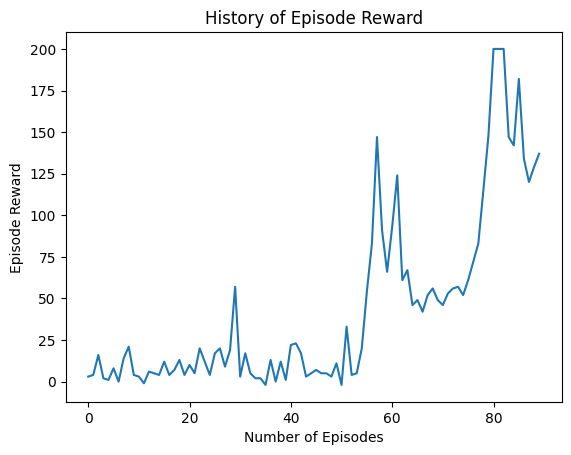

Reward:  173.0
Reward:  162.0


In [7]:
train_actor_critic()